<a href="https://colab.research.google.com/github/dqtuan99/SlimCAE_PyTorch/blob/main/SlimCAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===================================================================================
# 1. INSTALL AND CONFIGURE CONDA
# Using the environment variable method to accept the ToS.
# ===================================================================================
import os
os.environ['CONDA_PLUGINS_AUTO_ACCEPT_TOS'] = 'yes'
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local
!rm Miniconda3-latest-Linux-x86_64.sh
import sys
sys.path.append('/usr/local/lib/python3.13/site-packages')
print("✅ Conda installation complete.")

# ===================================================================================
# 2. CREATE THE ENVIRONMENT WITH PYTHON 3.7 AND CUDA 10.0
# We install Python and the necessary CUDA/cuDNN libraries together.
# ===================================================================================
print("\n⏳ Creating Python 3.7 environment with CUDA 10.0...")

!conda create -n tf1 python=3.7 cudatoolkit=10.0 cudnn=7.6 -y

# Install TensorFlow 1.13.1 and PIN the protobuf version to a compatible one.
!conda run -n tf1 pip install \
    tensorflow-gpu==1.13.1 \
    protobuf==3.19.4 \
    numpy==1.16.4 \
    keras==2.2.4 \
    h5py==2.10.0 \
    matplotlib

print("✅ TensorFlow 1.13.1 environment 'tf1' with compatible dependencies created successfully.")

# ===================================================================================
# 3. VERIFY THE INSTALLATION
# This should now succeed and show that the GPU is available.
# ===================================================================================
print("\n🔍 Verifying the installation...")
!conda run -n tf1 python -c "import sys; import tensorflow as tf; import numpy as np; print('-------------------------------------'); print('Python Version:', sys.version); print('TensorFlow Version:', tf.__version__); print('NumPy Version:', np.__version__); print('GPU Available:', tf.test.is_gpu_available()); print('-------------------------------------')"

--2025-08-19 09:41:31--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160039710 (153M) [application/octet-stream]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>] 152.62M   174MB/s    in 0.9s    

2025-08-19 09:41:32 (174 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [160039710/160039710]

PREFIX=/usr/local
Unpacking payload ...
entry_point.py:256: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
entry_point.py:256: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the f

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
%%writefile my_compression_script.py

import tensorflow as tf
print("TF version:", tf.__version__)

Writing my_compression_script.py


In [4]:
!conda run -n tf1 python my_compression_script.py

TF version: 1.13.1



In [5]:
# %%writefile SlimCAE.py

# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

# import sys
# sys.path.append('/content/drive/MyDrive/SlimCAE/tensorflow_compression.zip')

# import argparse
# import glob
# from os import listdir
# import os
# import scipy.io
# import csv
# import numpy as np
# import tensorflow as tf
# import tensorflow_compression as tfc

# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

# def load_image(filename):
#     """Loads a PNG image file."""
#     string = tf.read_file(filename)
#     image = tf.image.decode_image(string, channels=3)
#     image = tf.cast(image, tf.float32)
#     image /= 255
#     return image

# def quantize_image(image):
#     image = tf.clip_by_value(image, 0, 1)
#     image = tf.round(image * 255)
#     image = tf.cast(image, tf.uint8)
#     return image

# def save_image(filename, image):
#     """Saves an image to a PNG file."""
#     image = quantize_image(image)
#     string = tf.image.encode_png(image)
#     return tf.write_file(filename, string)

# # slimmable autoencoder -- encoder
# def slimmable_analysis_transform(tensor_in, switch_list, total_filters_num):
#     """Builds the slimmable analysis transform."""
#     with tf.variable_scope("analysis"):
#         tensor_encoder = list()
#         for i, _switch in enumerate(switch_list):
#             # the first conv and switchable gdn layers
#             with tf.variable_scope("layer_0",reuse=(i>0)):
#                 layer = tfc.SignalConv2D_slim(
#                     total_filters_num, (9, 9), corr=True, strides_down=4, padding="same_zeros",
#                     use_bias=True, activation=None)
#                 tensor = layer(tensor_in, 3, _switch)

#             with tf.variable_scope("gdn_an_0_{:1d}".format(i)):
#                 tensor_gdn_0 = tfc.GDN()(tensor)
#             tensor_gdn_0 = tf.pad(tensor_gdn_0, [[0,0], [0,0], [0,0], [0,(total_filters_num - _switch)]], "CONSTANT")

#             # the second conv and switchable gdn layers
#             with tf.variable_scope("layer_1",reuse=(i>0)):
#                 layer = tfc.SignalConv2D_slim(
#                     total_filters_num, (5, 5), corr=True, strides_down=2, padding="same_zeros",
#                     use_bias=True, activation=None)
#                 tensor = layer(tensor_gdn_0, _switch, _switch)

#             with tf.variable_scope("gdn_an_1_{:1d}".format(i)):
#                 tensor_gdn_1 = tfc.GDN()(tensor)
#             tensor_gdn_1 = tf.pad(tensor_gdn_1, [[0,0], [0,0], [0,0], [0,(total_filters_num - _switch)]], "CONSTANT")

#             # the third conv and switchable gdn layers
#             with tf.variable_scope("layer_2",reuse=(i>0)):
#                 layer = tfc.SignalConv2D_slim(
#                     total_filters_num, (5, 5), corr=True, strides_down=2, padding="same_zeros",
#                     use_bias=False, activation=None)
#                 tensor = layer(tensor_gdn_1, _switch, _switch)

#             with tf.variable_scope("gdn_an_2_{:1d}".format(i)):
#                 tensor_gdn_2 = tfc.GDN()(tensor)

#             # store the bottleneck features from different width
#             tensor_encoder.append(tensor_gdn_2)

#         return tensor_encoder

# # slimmable autoencoder -- decoder
# def slimmable_synthesis_transform(tensor_encoder, switch_list, total_filters_num):
#     """Builds the slimmable synthesis transform."""
#     with tf.variable_scope("synthesis"):
#         tensor_decoder = list()
#         for i, _switch in enumerate(switch_list):
#             # the first deconv and igdn layers
#             with tf.variable_scope("gdn_sy_0_{:1d}".format(i)):
#                 tensor_igdn_0 = tfc.GDN(inverse=True)(tensor_encoder[i])
#             tensor_igdn_0 = tf.pad(tensor_igdn_0, [[0,0], [0,0], [0,0], [0,(total_filters_num - _switch)]], "CONSTANT")

#             with tf.variable_scope("layer_0",reuse=(i>0)):
#                 layer = tfc.SignalConv2D_slim(
#                     total_filters_num, (5, 5), corr=False, strides_up=2, padding="same_zeros",
#                     use_bias=True, activation=None)
#                 tensor = layer(tensor_igdn_0, _switch, _switch)

#             # the second deconv and igdn layers
#             with tf.variable_scope("gdn_sy_1_{:1d}".format(i)):
#                 tensor_igdn_1 = tfc.GDN(inverse=True)(tensor)
#             tensor_igdn_1 = tf.pad(tensor_igdn_1, [[0,0], [0,0], [0,0], [0,(total_filters_num - _switch)]], "CONSTANT")

#             with tf.variable_scope("layer_1",reuse=(i>0)):
#                 layer = tfc.SignalConv2D_slim(
#                     total_filters_num, (5, 5), corr=False, strides_up=2, padding="same_zeros",
#                     use_bias=True, activation=None)
#                 tensor = layer(tensor_igdn_1, _switch, _switch)

#             # the third deconv and igdn layers
#             with tf.variable_scope("gdn_sy_2_{:1d}".format(i)):
#                 tensor_igdn_2 = tfc.GDN(inverse=True)(tensor)
#             tensor_igdn_2 = tf.pad(tensor_igdn_2, [[0,0], [0,0], [0,0], [0,(total_filters_num - _switch)]], "CONSTANT")

#             with tf.variable_scope("layer_2",reuse=(i>0)):
#                 layer = tfc.SignalConv2D_slim(
#                     3, (9, 9), corr=False, strides_up=4, padding="same_zeros",
#                     use_bias=True, activation=None)
#                 tensor = layer(tensor_igdn_2, _switch, 3)

#              # store the reconstructions from different width
#             tensor_decoder.append(tensor)

#         return tensor_decoder

# # train function
# def train(last_step, lmbdas):
#     """Trains the model."""

#     if args.verbose:
#         tf.logging.set_verbosity(tf.logging.INFO)

#     # create input data pipeline.
#     with tf.device('/cpu:0'):
#         train_files = glob.glob(args.train_glob)
#         train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
#         train_dataset = train_dataset.shuffle(buffer_size=len(train_files)).repeat()
#         train_dataset = train_dataset.map(
#             load_image, num_parallel_calls=args.preprocess_threads)
#         train_dataset = train_dataset.map(
#             lambda x: tf.random_crop(x, (args.patchsize, args.patchsize, 3)))
#         train_dataset = train_dataset.batch(args.batchsize)
#         train_dataset = train_dataset.prefetch(32)

#     num_pixels = args.batchsize * args.patchsize ** 2
#     total_filters_num = args.num_filters

#     # get training patch from dataset.
#     x = train_dataset.make_one_shot_iterator().get_next()

#     if args.train_jointly:
#         # lists to keep loss for each lambda
#         y_tilde, entropy_bottlenecks, likelihoods = list(), list(), list()
#         train_bpp, train_mse, train_loss = list(), list(), list()

#         # build a slimmable encoder
#         y = slimmable_analysis_transform(x, args.switch_list, total_filters_num)

#         for i, _switch in enumerate(args.switch_list):
#             entropy_bottlenecks.append(tfc.EntropyBottleneck())
#             _y_tilde, _likelihoods = entropy_bottlenecks[i](y[i], training=True)
#             y_tilde.append(_y_tilde)
#             likelihoods.append(_likelihoods)

#         # build a slimmable decoder
#         x_tilde = slimmable_synthesis_transform(y_tilde, args.switch_list, total_filters_num)

#         for i, _switch in enumerate(args.switch_list):
#             # Total number of bits divided by number of pixels.
#             train_bpp.append(tf.reduce_sum(tf.log(likelihoods[i])) / (-np.log(2) * num_pixels))

#             # Mean squared error across pixels.
#             train_mse.append(tf.reduce_mean(tf.squared_difference(x, x_tilde[i])))

#             # Multiply by 255^2 to correct for rescaling.
#             # train_mse[i] *= 255 ** 2

#             # The rate-distortion cost.
#             train_loss.append(lmbdas[i] * train_mse[i] + train_bpp[i])

#         # total loss
#         total_train_loss = tf.add_n(train_loss)

#         # minimize loss and auxiliary loss, and execute update op.
#         step = tf.train.create_global_step()
#         main_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
#         main_step = main_optimizer.minimize(total_train_loss, global_step=step)

#         aux_optimizers = list()
#         list_ops = [main_step]
#         for i, entropy_bottleneck in enumerate(entropy_bottlenecks):
#             aux_optimizers.append(tf.train.AdamOptimizer(learning_rate=1e-3))
#             list_ops.append(aux_optimizers[i].minimize(entropy_bottleneck.losses[0]))
#             list_ops.append(entropy_bottleneck.updates[0])
#         train_op = tf.group(list_ops)

#         # summaries
#         for i, _switch in enumerate(args.switch_list):
#             tf.summary.scalar("loss_%d" % i, train_loss[i])
#             tf.summary.scalar("bpp_%d" % i, train_bpp[i])
#             tf.summary.scalar("mse_%d" % i, train_mse[i]* 255 ** 2) # Rescaled
#             tf.summary.histogram("hist_y_%d" % i, y[i])

#         tf.summary.scalar("total_loss", total_train_loss)

#         hooks = [
#             tf.train.StopAtStepHook(last_step=last_step),
#             tf.train.NanTensorHook(total_train_loss),
#         ]

#         with tf.train.MonitoredTrainingSession(
#                 hooks=hooks, checkpoint_dir=args.checkpoint_dir,
#                 save_checkpoint_secs=900, save_summaries_secs=600) as sess:
#             while not sess.should_stop():
#                 sess.run(step)
#                 sess.run(train_op)

# def evaluate(last_step):
#     """Evaluate the model for test dataset"""

#     # process all the images in input_path
#     imagesList = listdir(args.inputPath)

#     # Initialize metric scores
#     bpp_estimate_total = [0.0] * len(args.switch_list)
#     mse_total = [0.0] * len(args.switch_list)
#     psnr_total = [0.0] * len(args.switch_list)
#     msssim_total = [0.0] * len(args.switch_list)
#     msssim_db_total = [0.0] * len(args.switch_list)

#     for image in imagesList:
#         entropy_bottlenecks = list()
#         y_hat, likelihoods, eval_bpp = list(), list(), list()
#         mse, psnr, msssim = list(), list(), list()

#         x = load_image(args.inputPath + image)
#         x = tf.expand_dims(x, 0)
#         x.set_shape([1, None, None, 3])

#         y = slimmable_analysis_transform(x, args.switch_list, args.num_filters)

#         for i, _switch in enumerate(args.switch_list):
#             entropy_bottlenecks.append(tfc.EntropyBottleneck())
#             #string_un = entropy_bottlenecks[i].compress(y[i])
#             _y_hat, _likelihoods = entropy_bottlenecks[i](y[i], training=False)
#             y_hat.append(_y_hat)
#             likelihoods.append(_likelihoods)

#         x_hat = slimmable_synthesis_transform(y_hat, args.switch_list, args.num_filters)

#         num_pixels = tf.to_float(tf.reduce_prod(tf.shape(x)[:-1]))

#         # Bring both images back to 0..255 range.
#         x *= 255

#         for i, _switch in enumerate(args.switch_list):
#             # Total number of bits divided by number of pixels.
#             eval_bpp.append(tf.reduce_sum(tf.log(likelihoods[i])) / (-np.log(2) * num_pixels))
#             x_rec = tf.clip_by_value(x_hat[i], 0, 1)
#             x_rec = tf.round(x_rec * 255)
#             x_rec = tf.slice(x_rec, [0, 0, 0, 0], [1,tf.shape(x)[1], tf.shape(x)[2], 3])

#             mse.append(tf.reduce_mean(tf.squared_difference(x, x_rec)))
#             psnr.append(tf.squeeze(tf.image.psnr(x_rec, x, 255)))
#             msssim.append(tf.squeeze(tf.image.ssim_multiscale(x_rec, x, 255)))

#         with tf.Session() as sess:
#             # Load the latest model checkpoint, get the evaluation results.
#             latest = tf.train.latest_checkpoint(checkpoint_dir=args.checkpoint_dir)
#             tf.train.Saver().restore(sess, save_path=latest)

#             eval_bpp, mse, psnr, msssim, num_pixels = sess.run(
#                 [eval_bpp, mse, psnr, msssim, num_pixels])

#         # print RD results
#         for i, _switch in enumerate(args.switch_list):
#             print("Switch level:{:1d}".format(i))
#             print("Mean squared error: {:0.4f}".format(mse[i]))
#             print("PSNR (dB): {:0.2f}".format(psnr[i]))
#             print("Multiscale SSIM: {:0.4f}".format(msssim[i]))
#             print("Multiscale SSIM (dB): {:0.2f}".format(-10 * np.log10(1 - msssim[i])))
#             print("Information content in bpp: {:0.4f}".format(eval_bpp[i]))

#             bpp_estimate_total[i] += eval_bpp[i]
#             mse_total[i] += mse[i]
#             psnr_total[i] += psnr[i]
#             msssim_total[i] += msssim[i]
#             msssim_db_total[i] += (-10 * np.log10(1 - msssim[i]))

#         tf.reset_default_graph()

#     if args.evaluation_name is not None:
#         Avg_bpp_estimate = np.array(bpp_estimate_total) / len(imagesList)
#         Avg_mse, Avg_psnr = np.array(mse_total) / len(imagesList), np.array(psnr_total) / len(imagesList)
#         Avg_msssim, Avg_msssim_db = np.array(msssim_total) / len(imagesList), np.array(msssim_db_total) / len(imagesList)
#         with open (args.evaluation_name + str(last_step) + '.txt', 'w') as f:
#             f.write('Avg_bpp_estimate: '+str(Avg_bpp_estimate)+'\n')
#             f.write('Avg_mse: '+str(Avg_mse)+'\n')
#             f.write('Avg_psnr: '+str(Avg_psnr)+'\n')
#             f.write('Avg_msssim: '+str(Avg_msssim)+'\n')
#             f.write('Avg_msssim_db: '+str(Avg_msssim_db)+'\n')

#     return Avg_bpp_estimate, Avg_psnr

# def train_loop():
#     "search the optimal RD points in a slimmable compressive autoencoder"
#     # the number of iterations
#     last_step = args.last_step
#     # initial RD tradeoffs
#     lmbdas = args.lmbda
#     # train SlimCAE as stage 1
#     train(last_step, lmbdas)
#     tf.reset_default_graph()
#     # evaluate model with validation dataset
#     bpp, psnr = evaluate(last_step)

#     lambda_log = list()
#     grad_flag_log = list()
#     grad_current_log = list()

#     # train SlimCAE with lambda scheduling as stage 2
#     for i in range(len(lmbdas)-1):
#         grad_flag = (psnr[i] - psnr[i+1]) / (bpp[i] - bpp[i+1])
#         factor = 1
#         m = 1
#         while True:
#             lmbdas[(i+1):] = [0.8 * element for element in lmbdas[(i+1):]] # adjust the lambda values
#             lambda_log.append(lmbdas)
#             last_step += 20
#             train(last_step, lmbdas) # train the model with more iterations
#             tf.reset_default_graph()
#             bpp, psnr = evaluate(last_step)
#             tf.reset_default_graph()
#             grad_current = (psnr[i] - psnr[i+1]) / (bpp[i] - bpp[i+1])
#             grad_flag_log.append(grad_flag)
#             grad_current_log.append(grad_current)
#             if grad_current > grad_flag:
#                 break
#             else:
#                 if m == 1:
#                     factor_flag = grad_flag - grad_current
#                 elif m < 7:
#                     factor = (grad_flag - grad_current) / factor_flag
#                     factor_flag = grad_flag - grad_current
#                 else:
#                     break
#                 grad_flag = grad_current
#                 m += 1

#     # save log files during the lambda scheduling
#     with open('lmbdaslog', 'w') as myfile:
#         wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#         wr.writerow(lambda_log)

#     with open('grad_flag_log', 'w') as myfile:
#         wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#         wr.writerow(grad_flag_log)

#     with open('grad_current_log', 'w') as myfile:
#         wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#         wr.writerow(grad_current_log)


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser(
#         formatter_class=argparse.ArgumentDefaultsHelpFormatter)

#     parser.add_argument(
#         "command", choices=["train", "evaluate", "train_lambda_schedule"],
#         help="What to do: 'train' loads training data and trains "
#              "a new model. 'evaluate' loads a pre-trained model and "
#              "evaluates on a given dataset. 'train_lambda_schedule' "
#              "means train a new model with lambda scheduling. ")
#     parser.add_argument(
#         "--verbose", "-v", action="store_true",
#         help="Report bitrate and distortion when training or compressing.")
#     parser.add_argument(
#         "--num_filters", type=int, default=128,
#         help="Number of filters per layer.")
#     parser.add_argument(
#         "--checkpoint_dir", default="train",
#         help="Directory where to save/load model checkpoints.")
#     parser.add_argument(
#         "--train_glob", default="images/*.png",
#         help="Glob pattern identifying training data. This pattern must expand "
#              "to a list of RGB images in PNG format.")
#     parser.add_argument(
#         "--batchsize", type=int, default=8,
#         help="Batch size for training.")
#     parser.add_argument(
#         "--patchsize", type=int, default=256,
#         help="Size of image patches for training.")
#     parser.add_argument(
#         "--lambda", nargs="+", type=float, default=[512], dest="lmbda",
#         help="Lambdas for rate-distortion tradeoff point.")
#     parser.add_argument(
#         "--last_step", type=int, default=800000,
#         help="Train up to this number of steps.")
#     parser.add_argument(
#         "--preprocess_threads", type=int, default=6,
#         help="Number of CPU threads to use for parallel decoding of training "
#              "images.")
#     parser.add_argument(
#         "--switch_list", nargs="+", type=int, default=[64],
#         help="Number of filters per layer.")
#     parser.add_argument(
#         "--evaluation_name", type=str, default='./searchRDpoints/One',
#         help="the name of evaluation results txt file.")
#     parser.add_argument(
#         "--inputPath", type=str, default=None,
#         help="Directory where to evaluation dataset.")
#     parser.add_argument(
#         "--train_jointly", action="store_true",
#         help="train all the variables together.")

#     args = parser.parse_args()
#     if args.command == "train":
#         train(args.last_step, args.lmbda)
#     elif args.command == "train_lambda_schedule":
#         train_loop()
#     elif args.command == "evaluate":
#         if args.inputPath is None:
#             raise ValueError("Need input path for evaluation.")
#         evaluate(args.last_step)

In [6]:
!conda run -n tf1 pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.1 MB/s eta 0:00:00



In [7]:
%%writefile SlimCAE.py

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tqdm import tqdm  # <--- ADDED
import sys
sys.path.append('/content/drive/MyDrive/SlimCAE/tensorflow_compression.zip')

import argparse
import glob
from os import listdir
import os
import scipy.io
import csv
import numpy as np
import tensorflow as tf
import tensorflow_compression as tfc

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def load_image(filename):
    """Loads a PNG image file."""
    string = tf.read_file(filename)
    image = tf.image.decode_image(string, channels=3)
    image = tf.cast(image, tf.float32)
    image /= 255
    return image

def quantize_image(image):
    image = tf.clip_by_value(image, 0, 1)
    image = tf.round(image * 255)
    image = tf.cast(image, tf.uint8)
    return image

def save_image(filename, image):
    """Saves an image to a PNG file."""
    image = quantize_image(image)
    string = tf.image.encode_png(image)
    return tf.write_file(filename, string)

# slimmable autoencoder -- encoder
def slimmable_analysis_transform(tensor_in, switch_list, total_filters_num):
    """Builds the slimmable analysis transform."""
    with tf.variable_scope("analysis"):
        tensor_encoder = list()
        for i, _switch in enumerate(switch_list):
            # the first conv and switchable gdn layers
            with tf.variable_scope("layer_0", reuse=(i > 0)):
                layer = tfc.SignalConv2D_slim(
                    total_filters_num, (9, 9), corr=True, strides_down=4, padding="same_zeros",
                    use_bias=True, activation=None)
                tensor = layer(tensor_in, 3, _switch)

            with tf.variable_scope("gdn_an_0_{:1d}".format(i)):
                tensor_gdn_0 = tfc.GDN()(tensor)
            tensor_gdn_0 = tf.pad(tensor_gdn_0, [[0, 0], [0, 0], [0, 0], [0, (total_filters_num - _switch)]], "CONSTANT")

            # the second conv and switchable gdn layers
            with tf.variable_scope("layer_1", reuse=(i > 0)):
                layer = tfc.SignalConv2D_slim(
                    total_filters_num, (5, 5), corr=True, strides_down=2, padding="same_zeros",
                    use_bias=True, activation=None)
                tensor = layer(tensor_gdn_0, _switch, _switch)

            with tf.variable_scope("gdn_an_1_{:1d}".format(i)):
                tensor_gdn_1 = tfc.GDN()(tensor)
            tensor_gdn_1 = tf.pad(tensor_gdn_1, [[0, 0], [0, 0], [0, 0], [0, (total_filters_num - _switch)]], "CONSTANT")

            # the third conv and switchable gdn layers
            with tf.variable_scope("layer_2", reuse=(i > 0)):
                layer = tfc.SignalConv2D_slim(
                    total_filters_num, (5, 5), corr=True, strides_down=2, padding="same_zeros",
                    use_bias=False, activation=None)
                tensor = layer(tensor_gdn_1, _switch, _switch)

            with tf.variable_scope("gdn_an_2_{:1d}".format(i)):
                tensor_gdn_2 = tfc.GDN()(tensor)

            # store the bottleneck features from different width
            tensor_encoder.append(tensor_gdn_2)

        return tensor_encoder

# slimmable autoencoder -- decoder
def slimmable_synthesis_transform(tensor_encoder, switch_list, total_filters_num):
    """Builds the slimmable synthesis transform."""
    with tf.variable_scope("synthesis"):
        tensor_decoder = list()
        for i, _switch in enumerate(switch_list):
            # the first deconv and igdn layers
            with tf.variable_scope("gdn_sy_0_{:1d}".format(i)):
                tensor_igdn_0 = tfc.GDN(inverse=True)(tensor_encoder[i])
            tensor_igdn_0 = tf.pad(tensor_igdn_0, [[0, 0], [0, 0], [0, 0], [0, (total_filters_num - _switch)]], "CONSTANT")

            with tf.variable_scope("layer_0", reuse=(i > 0)):
                layer = tfc.SignalConv2D_slim(
                    total_filters_num, (5, 5), corr=False, strides_up=2, padding="same_zeros",
                    use_bias=True, activation=None)
                tensor = layer(tensor_igdn_0, _switch, _switch)

            # the second deconv and igdn layers
            with tf.variable_scope("gdn_sy_1_{:1d}".format(i)):
                tensor_igdn_1 = tfc.GDN(inverse=True)(tensor)
            tensor_igdn_1 = tf.pad(tensor_igdn_1, [[0, 0], [0, 0], [0, 0], [0, (total_filters_num - _switch)]], "CONSTANT")

            with tf.variable_scope("layer_1", reuse=(i > 0)):
                layer = tfc.SignalConv2D_slim(
                    total_filters_num, (5, 5), corr=False, strides_up=2, padding="same_zeros",
                    use_bias=True, activation=None)
                tensor = layer(tensor_igdn_1, _switch, _switch)

            # the third deconv and igdn layers
            with tf.variable_scope("gdn_sy_2_{:1d}".format(i)):
                tensor_igdn_2 = tfc.GDN(inverse=True)(tensor)
            tensor_igdn_2 = tf.pad(tensor_igdn_2, [[0, 0], [0, 0], [0, 0], [0, (total_filters_num - _switch)]], "CONSTANT")

            with tf.variable_scope("layer_2", reuse=(i > 0)):
                layer = tfc.SignalConv2D_slim(
                    3, (9, 9), corr=False, strides_up=4, padding="same_zeros",
                    use_bias=True, activation=None)
                tensor = layer(tensor_igdn_2, _switch, 3)

            # store the reconstructions from different width
            tensor_decoder.append(tensor)

        return tensor_decoder

# train function
def train(last_step, lmbdas):
    """Trains the model."""

    if args.verbose:
        tf.logging.set_verbosity(tf.logging.INFO)

    # create input data pipeline.
    with tf.device('/cpu:0'):
        train_files = glob.glob(args.train_glob)
        train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
        train_dataset = train_dataset.shuffle(buffer_size=len(train_files)).repeat()
        train_dataset = train_dataset.map(
            load_image, num_parallel_calls=args.preprocess_threads)
        train_dataset = train_dataset.map(
            lambda x: tf.random_crop(x, (args.patchsize, args.patchsize, 3)))
        train_dataset = train_dataset.batch(args.batchsize)
        train_dataset = train_dataset.prefetch(32)

    num_pixels = args.batchsize * args.patchsize ** 2
    total_filters_num = args.num_filters

    # get training patch from dataset.
    x = train_dataset.make_one_shot_iterator().get_next()

    if args.train_jointly:
        # lists to keep loss for each lambda
        y_tilde, entropy_bottlenecks, likelihoods = list(), list(), list()
        train_bpp, train_mse, train_loss = list(), list(), list()

        # build a slimmable encoder
        y = slimmable_analysis_transform(x, args.switch_list, total_filters_num)

        for i, _switch in enumerate(args.switch_list):
            entropy_bottlenecks.append(tfc.EntropyBottleneck())
            _y_tilde, _likelihoods = entropy_bottlenecks[i](y[i], training=True)
            y_tilde.append(_y_tilde)
            likelihoods.append(_likelihoods)

        # build a slimmable decoder
        x_tilde = slimmable_synthesis_transform(y_tilde, args.switch_list, total_filters_num)

        for i, _switch in enumerate(args.switch_list):
            # Total number of bits divided by number of pixels.
            train_bpp.append(tf.reduce_sum(tf.log(likelihoods[i])) / (-np.log(2) * num_pixels))

            # Mean squared error across pixels.
            train_mse.append(tf.reduce_mean(tf.squared_difference(x, x_tilde[i])))

            # Multiply by 255^2 to correct for rescaling.
            # train_mse[i] *= 255 ** 2

            # The rate-distortion cost.
            train_loss.append(lmbdas[i] * train_mse[i] + train_bpp[i])

        # total loss
        total_train_loss = tf.add_n(train_loss)

        # minimize loss and auxiliary loss, and execute update op.
        step = tf.train.create_global_step()
        main_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
        main_step = main_optimizer.minimize(total_train_loss, global_step=step)

        aux_optimizers = list()
        list_ops = [main_step]
        for i, entropy_bottleneck in enumerate(entropy_bottlenecks):
            aux_optimizers.append(tf.train.AdamOptimizer(learning_rate=1e-3))
            list_ops.append(aux_optimizers[i].minimize(entropy_bottleneck.losses[0]))
            list_ops.append(entropy_bottleneck.updates[0])
        train_op = tf.group(list_ops)

        # summaries
        for i, _switch in enumerate(args.switch_list):
            tf.summary.scalar("loss_%d" % i, train_loss[i])
            tf.summary.scalar("bpp_%d" % i, train_bpp[i])
            tf.summary.scalar("mse_%d" % i, train_mse[i] * 255 ** 2)  # Rescaled
            tf.summary.histogram("hist_y_%d" % i, y[i])

        tf.summary.scalar("total_loss", total_train_loss)

        hooks = [
            tf.train.StopAtStepHook(last_step=last_step),
            tf.train.NanTensorHook(total_train_loss),
        ]

        with tf.train.MonitoredTrainingSession(
                hooks=hooks, checkpoint_dir=args.checkpoint_dir,
                save_checkpoint_secs=900, save_summaries_secs=600) as sess:
            # --- TQDM SETUP --- # <--- ADDED
            initial_step = sess.run(step)
            pbar = tqdm(total=last_step, initial=initial_step, desc="Training")
            # -------------------- # <--- ADDED
            while not sess.should_stop():
                sess.run(train_op)
                pbar.update(1)  # <--- ADDED
            pbar.close()  # <--- ADDED

def evaluate(last_step):
    """Evaluate the model for test dataset"""

    # process all the images in input_path
    imagesList = listdir(args.inputPath)

    # Initialize metric scores
    bpp_estimate_total = [0.0] * len(args.switch_list)
    mse_total = [0.0] * len(args.switch_list)
    psnr_total = [0.0] * len(args.switch_list)
    msssim_total = [0.0] * len(args.switch_list)
    msssim_db_total = [0.0] * len(args.switch_list)

    for image in tqdm(imagesList, desc="Evaluating"):  # <--- MODIFIED
        entropy_bottlenecks = list()
        y_hat, likelihoods, eval_bpp = list(), list(), list()
        mse, psnr, msssim = list(), list(), list()

        x = load_image(args.inputPath + image)
        x = tf.expand_dims(x, 0)
        x.set_shape([1, None, None, 3])

        y = slimmable_analysis_transform(x, args.switch_list, args.num_filters)

        for i, _switch in enumerate(args.switch_list):
            entropy_bottlenecks.append(tfc.EntropyBottleneck())
            # string_un = entropy_bottlenecks[i].compress(y[i])
            _y_hat, _likelihoods = entropy_bottlenecks[i](y[i], training=False)
            y_hat.append(_y_hat)
            likelihoods.append(_likelihoods)

        x_hat = slimmable_synthesis_transform(y_hat, args.switch_list, args.num_filters)

        num_pixels = tf.to_float(tf.reduce_prod(tf.shape(x)[:-1]))

        # Bring both images back to 0..255 range.
        x *= 255

        for i, _switch in enumerate(args.switch_list):
            # Total number of bits divided by number of pixels.
            eval_bpp.append(tf.reduce_sum(tf.log(likelihoods[i])) / (-np.log(2) * num_pixels))
            x_rec = tf.clip_by_value(x_hat[i], 0, 1)
            x_rec = tf.round(x_rec * 255)
            x_rec = tf.slice(x_rec, [0, 0, 0, 0], [1, tf.shape(x)[1], tf.shape(x)[2], 3])

            mse.append(tf.reduce_mean(tf.squared_difference(x, x_rec)))
            psnr.append(tf.squeeze(tf.image.psnr(x_rec, x, 255)))
            msssim.append(tf.squeeze(tf.image.ssim_multiscale(x_rec, x, 255)))

        with tf.Session() as sess:
            # Load the latest model checkpoint, get the evaluation results.
            latest = tf.train.latest_checkpoint(checkpoint_dir=args.checkpoint_dir)
            tf.train.Saver().restore(sess, save_path=latest)

            eval_bpp, mse, psnr, msssim, num_pixels = sess.run(
                [eval_bpp, mse, psnr, msssim, num_pixels])

        # print RD results
        for i, _switch in enumerate(args.switch_list):
            print("Switch level:{:1d}".format(i))
            print("Mean squared error: {:0.4f}".format(mse[i]))
            print("PSNR (dB): {:0.2f}".format(psnr[i]))
            print("Multiscale SSIM: {:0.4f}".format(msssim[i]))
            print("Multiscale SSIM (dB): {:0.2f}".format(-10 * np.log10(1 - msssim[i])))
            print("Information content in bpp: {:0.4f}".format(eval_bpp[i]))

            bpp_estimate_total[i] += eval_bpp[i]
            mse_total[i] += mse[i]
            psnr_total[i] += psnr[i]
            msssim_total[i] += msssim[i]
            msssim_db_total[i] += (-10 * np.log10(1 - msssim[i]))

        tf.reset_default_graph()

    if args.evaluation_name is not None:
        Avg_bpp_estimate = np.array(bpp_estimate_total) / len(imagesList)
        Avg_mse, Avg_psnr = np.array(mse_total) / len(imagesList), np.array(psnr_total) / len(imagesList)
        Avg_msssim, Avg_msssim_db = np.array(msssim_total) / len(imagesList), np.array(msssim_db_total) / len(imagesList)
        with open(args.evaluation_name + str(last_step) + '.txt', 'w') as f:
            f.write('Avg_bpp_estimate: ' + str(Avg_bpp_estimate) + '\n')
            f.write('Avg_mse: ' + str(Avg_mse) + '\n')
            f.write('Avg_psnr: ' + str(Avg_psnr) + '\n')
            f.write('Avg_msssim: ' + str(Avg_msssim) + '\n')
            f.write('Avg_msssim_db: ' + str(Avg_msssim_db) + '\n')

    return Avg_bpp_estimate, Avg_psnr

def train_loop():
    "search the optimal RD points in a slimmable compressive autoencoder"
    # the number of iterations
    last_step = args.last_step
    # initial RD tradeoffs
    lmbdas = args.lmbda
    # train SlimCAE as stage 1
    train(last_step, lmbdas)
    tf.reset_default_graph()
    # evaluate model with validation dataset
    bpp, psnr = evaluate(last_step)

    lambda_log = list()
    grad_flag_log = list()
    grad_current_log = list()

    # train SlimCAE with lambda scheduling as stage 2
    for i in tqdm(range(len(lmbdas) - 1), desc="Lambda Scheduling"):  # <--- MODIFIED
        grad_flag = (psnr[i] - psnr[i + 1]) / (bpp[i] - bpp[i + 1])
        factor = 1
        m = 1
        while True:
            lmbdas[(i + 1):] = [0.8 * element for element in lmbdas[(i + 1):]]  # adjust the lambda values
            lambda_log.append(lmbdas)
            last_step += 20
            train(last_step, lmbdas)  # train the model with more iterations
            tf.reset_default_graph()
            bpp, psnr = evaluate(last_step)
            tf.reset_default_graph()
            grad_current = (psnr[i] - psnr[i + 1]) / (bpp[i] - bpp[i + 1])
            grad_flag_log.append(grad_flag)
            grad_current_log.append(grad_current)
            if grad_current > grad_flag:
                break
            else:
                if m == 1:
                    factor_flag = grad_flag - grad_current
                elif m < 7:
                    factor = (grad_flag - grad_current) / factor_flag
                    factor_flag = grad_flag - grad_current
                else:
                    break
                grad_flag = grad_current
                m += 1

    # save log files during the lambda scheduling
    with open('lmbdaslog', 'w') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(lambda_log)

    with open('grad_flag_log', 'w') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(grad_flag_log)

    with open('grad_current_log', 'w') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(grad_current_log)


if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter)

    parser.add_argument(
        "command", choices=["train", "evaluate", "train_lambda_schedule"],
        help="What to do: 'train' loads training data and trains "
             "a new model. 'evaluate' loads a pre-trained model and "
             "evaluates on a given dataset. 'train_lambda_schedule' "
             "means train a new model with lambda scheduling. ")
    parser.add_argument(
        "--verbose", "-v", action="store_true",
        help="Report bitrate and distortion when training or compressing.")
    parser.add_argument(
        "--num_filters", type=int, default=128,
        help="Number of filters per layer.")
    parser.add_argument(
        "--checkpoint_dir", default="train",
        help="Directory where to save/load model checkpoints.")
    parser.add_argument(
        "--train_glob", default="images/*.png",
        help="Glob pattern identifying training data. This pattern must expand "
             "to a list of RGB images in PNG format.")
    parser.add_argument(
        "--batchsize", type=int, default=8,
        help="Batch size for training.")
    parser.add_argument(
        "--patchsize", type=int, default=256,
        help="Size of image patches for training.")
    parser.add_argument(
        "--lambda", nargs="+", type=float, default=[512], dest="lmbda",
        help="Lambdas for rate-distortion tradeoff point.")
    parser.add_argument(
        "--last_step", type=int, default=800000,
        help="Train up to this number of steps.")
    parser.add_argument(
        "--preprocess_threads", type=int, default=6,
        help="Number of CPU threads to use for parallel decoding of training "
             "images.")
    parser.add_argument(
        "--switch_list", nargs="+", type=int, default=[64],
        help="Number of filters per layer.")
    parser.add_argument(
        "--evaluation_name", type=str, default='./searchRDpoints/One',
        help="the name of evaluation results txt file.")
    parser.add_argument(
        "--inputPath", type=str, default=None,
        help="Directory where to evaluation dataset.")
    parser.add_argument(
        "--train_jointly", action="store_true",
        help="train all the variables together.")

    args = parser.parse_args()
    if args.command == "train":
        train(args.last_step, args.lmbda)
    elif args.command == "train_lambda_schedule":
        train_loop()
    elif args.command == "evaluate":
        if args.inputPath is None:
            raise ValueError("Need input path for evaluation.")
        evaluate(args.last_step)

Writing SlimCAE.py


In [ ]:
# This copies the data to the fast local disk
!unzip /content/drive/MyDrive/SlimCAE/train.zip -d /content/dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/000000000139.jpg  
  inflating: /content/dataset/train/000000000285.jpg  
  inflating: /content/dataset/train/000000000632.jpg  
  inflating: /content/dataset/train/000000000724.jpg  
  inflating: /content/dataset/train/000000000776.jpg  
  inflating: /content/dataset/train/000000000785.jpg  
  inflating: /content/dataset/train/000000000802.jpg  
  inflating: /content/dataset/train/000000000872.jpg  
  inflating: /content/dataset/train/000000000885.jpg  
  inflating: /content/dataset/train/000000001000.jpg  
  inflating: /content/dataset/train/000000001268.jpg  
  inflating: /content/dataset/train/000000001296.jpg  
  inflating: /content/dataset/train/000000001353.jpg  
  inflating: /content/dataset/train/000000001425.jpg  
  inflating: /content/dataset/train/000000001490.jpg  
  inflating: /content/dataset/train/000000001503.jpg  
  inflating: /content/dataset/train/000000001532.jpg  
  inflating: /

In [ ]:
!conda run -n tf1 python SlimCAE.py -v --train_glob='/content/dataset/train/*.jpg' --patchsize 128 --num_filter 192 --switch_list 192 144 96 72 48 --train_jointly --lambda 2048 1024 512 256 128 --last_step 1000000 --checkpoint_dir='/content/drive/MyDrive/SlimCAE/checkpoints/' train

In [12]:
# This copies the data to the fast local disk
!unzip /content/drive/MyDrive/SlimCAE/test.zip -d /content/dataset/

Archive:  /content/drive/MyDrive/SlimCAE/test.zip
replace /content/dataset/test/aaron-greenwood-x9zy_1oHjqw-unsplash.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [15]:
!conda run -n tf1 python SlimCAE.py --num_filter 192 --switch_list 192 144 96 72 48 --checkpoint_dir='/content/drive/MyDrive/SlimCAE/checkpoints/' --inputPath='/content/dataset/test/' --evaluation_name='/content/drive/MyDrive/SlimCAE/evaluation/' evaluate

Switch level:0
Mean squared error: 22.4439
PSNR (dB): 34.62
Multiscale SSIM: 0.9883
Multiscale SSIM (dB): 19.31
Information content in bpp: 0.9213
Switch level:1
Mean squared error: 33.5489
PSNR (dB): 32.87
Multiscale SSIM: 0.9833
Multiscale SSIM (dB): 17.77
Information content in bpp: 0.6135
Switch level:2
Mean squared error: 52.6301
PSNR (dB): 30.92
Multiscale SSIM: 0.9752
Multiscale SSIM (dB): 16.06
Information content in bpp: 0.4011
Switch level:3
Mean squared error: 79.5917
PSNR (dB): 29.12
Multiscale SSIM: 0.9632
Multiscale SSIM (dB): 14.34
Information content in bpp: 0.2577
Switch level:4
Mean squared error: 127.9169
PSNR (dB): 27.06
Multiscale SSIM: 0.9439
Multiscale SSIM (dB): 12.51
Information content in bpp: 0.1515
Switch level:0
Mean squared error: 9.4706
PSNR (dB): 38.37
Multiscale SSIM: 0.9912
Multiscale SSIM (dB): 20.54
Information content in bpp: 0.6935
Switch level:1
Mean squared error: 14.2492
PSNR (dB): 36.59
Multiscale SSIM: 0.9880
Multiscale SSIM (dB): 19.22
Inform

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Individual Metric Plots ---


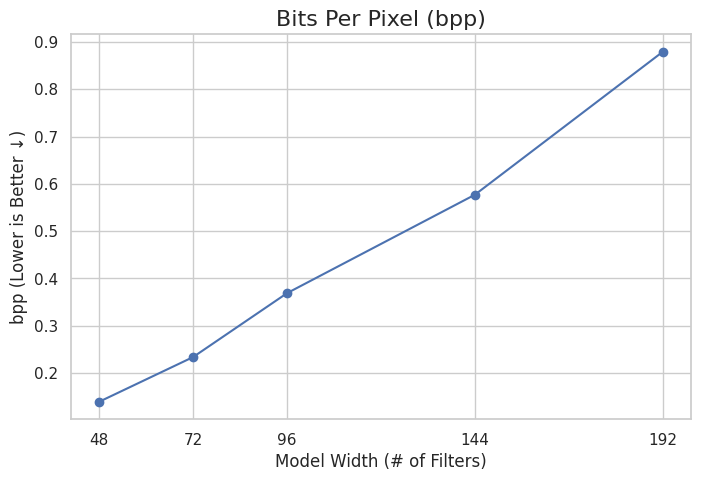

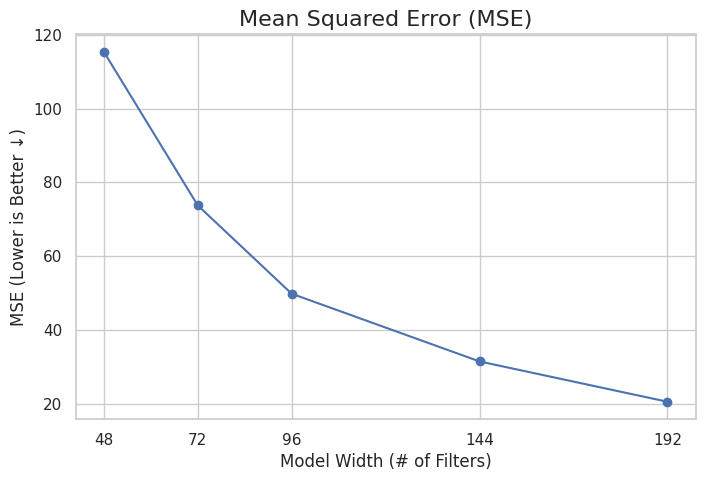

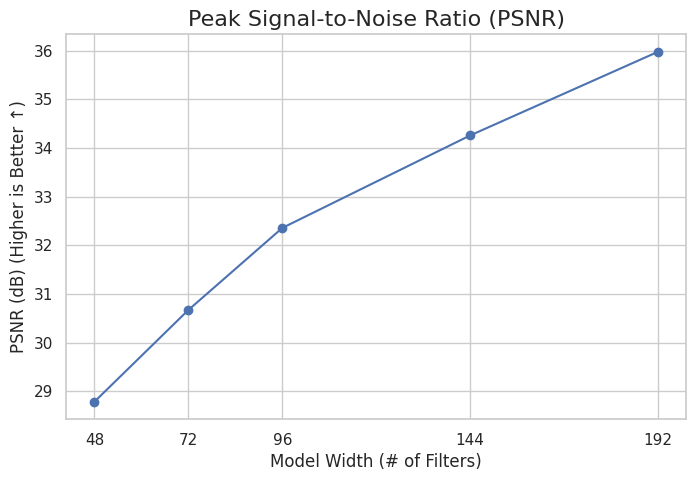

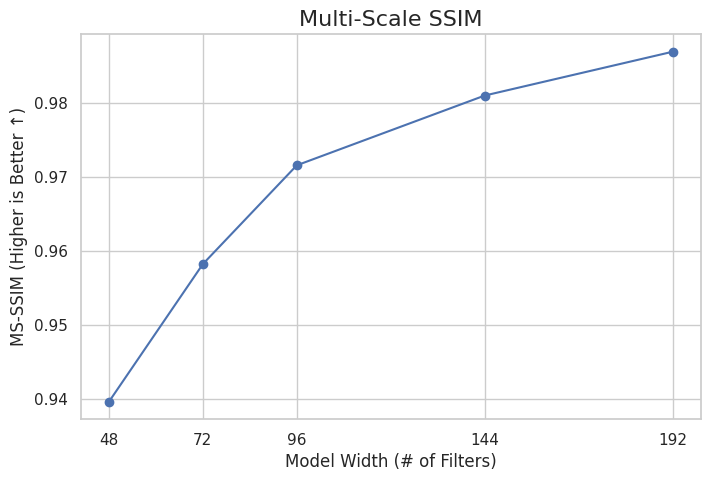

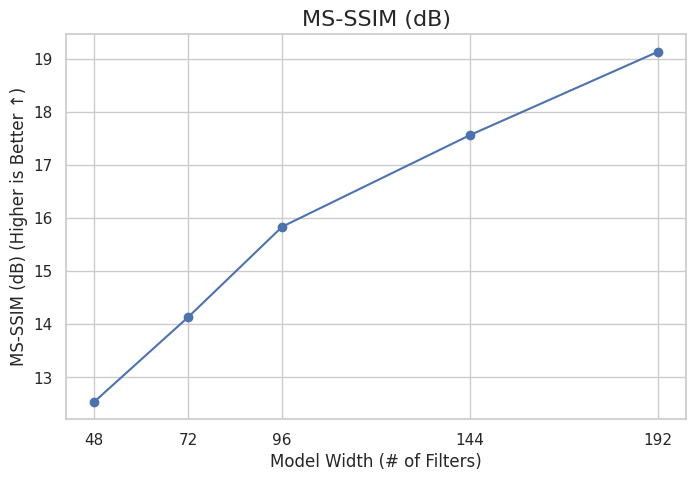


--- Rate-Distortion Curve ---


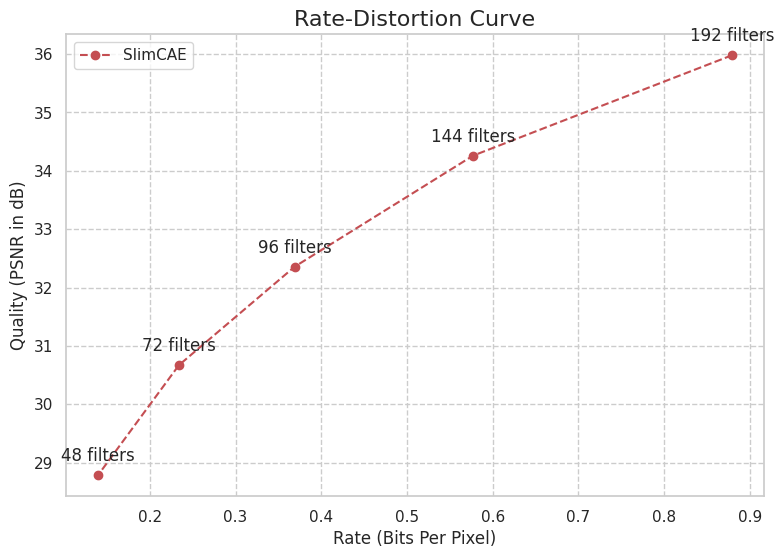

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

widths = [192, 144, 96, 72, 48]
data_filename = '/content/drive/MyDrive/SlimCAE/evaluation/800000.txt' # <-- Path to your file

# --- Read and MANUALLY parse the data from the text file ---
metrics = {}
try:
    with open(data_filename, 'r') as f:
        for line in f:
            if ':' in line:
                key, value_str = line.split(':', 1)

                # --- NEW PARSING LOGIC ---
                # 1. Clean the string: remove brackets and whitespace
                cleaned_str = value_str.strip().strip('[]')
                # 2. Split by whitespace and convert each number to a float
                values = [float(num) for num in cleaned_str.split()]
                # --- END NEW LOGIC ---

                metrics[key.strip()] = values
except FileNotFoundError:
    print(f"ERROR: The file was not found at {data_filename}")
    print("Please make sure the path is correct and your Google Drive is mounted.")
except Exception as e:
    print(f"An error occurred while parsing the file: {e}")


# Proceed with plotting only if the metrics dictionary was successfully populated
if metrics:
    # Extract the data into variables for easier access
    bpp = metrics['Avg_bpp_estimate']
    mse = metrics['Avg_mse']
    psnr = metrics['Avg_psnr']
    msssim = metrics['Avg_msssim']
    msssim_db = metrics['Avg_msssim_db']

    # Set a nice theme for the plots
    sns.set_theme(style="whitegrid")

    # --- 4. Plotting Individual Metrics vs. Model Width ---
    sorted_data = sorted(zip(widths, bpp, mse, psnr, msssim, msssim_db))
    s_widths, s_bpp, s_mse, s_psnr, s_msssim, s_msssim_db = zip(*sorted_data)

    metrics_to_plot = [
        (s_bpp, "Bits Per Pixel (bpp)", "bpp (Lower is Better ↓)"),
        (s_mse, "Mean Squared Error (MSE)", "MSE (Lower is Better ↓)"),
        (s_psnr, "Peak Signal-to-Noise Ratio (PSNR)", "PSNR (dB) (Higher is Better ↑)"),
        (s_msssim, "Multi-Scale SSIM", "MS-SSIM (Higher is Better ↑)"),
        (s_msssim_db, "MS-SSIM (dB)", "MS-SSIM (dB) (Higher is Better ↑)")
    ]

    print("--- Individual Metric Plots ---")
    for data, title, ylabel in metrics_to_plot:
        plt.figure(figsize=(8, 5))
        plt.plot(s_widths, data, marker='o', linestyle='-', color='b')
        plt.title(title, fontsize=16)
        plt.xlabel("Model Width (# of Filters)", fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.xticks(s_widths)
        plt.show()

    # --- 5. Plotting the Rate-Distortion (RD) Curve ---
    print("\n--- Rate-Distortion Curve ---")
    plt.figure(figsize=(9, 6))
    plt.plot(bpp, psnr, marker='o', linestyle='--', color='r', label='SlimCAE')

    for i, width in enumerate(widths):
        plt.annotate(f"{width} filters", (bpp[i], psnr[i]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')

    plt.title("Rate-Distortion Curve", fontsize=16)
    plt.xlabel("Rate (Bits Per Pixel)", fontsize=12)
    plt.ylabel("Quality (PSNR in dB)", fontsize=12)
    plt.legend()
    plt.grid(True, which="both", linestyle='--')
    plt.show()